## 透過 Parsing Tesla 的 Sales 資料學習爬蟲和 ChatGPT 應用

這份檔案是用來學習如何透過 ChatGPT 來完成把 Tesla 的銷售轉成 DataFrame 格式方便用於後續分析用途

在往下看之前，建議可以自己嘗試看看

如果今天需求是：
從這個 wikipedia 網站
https://en.wikipedia.org/wiki/History_of_Tesla,_Inc.#Timeline_of_production_and_sales

把以下 Table Parsing 成為 DataFrame 並且把 Total Sales 畫出趨勢圖
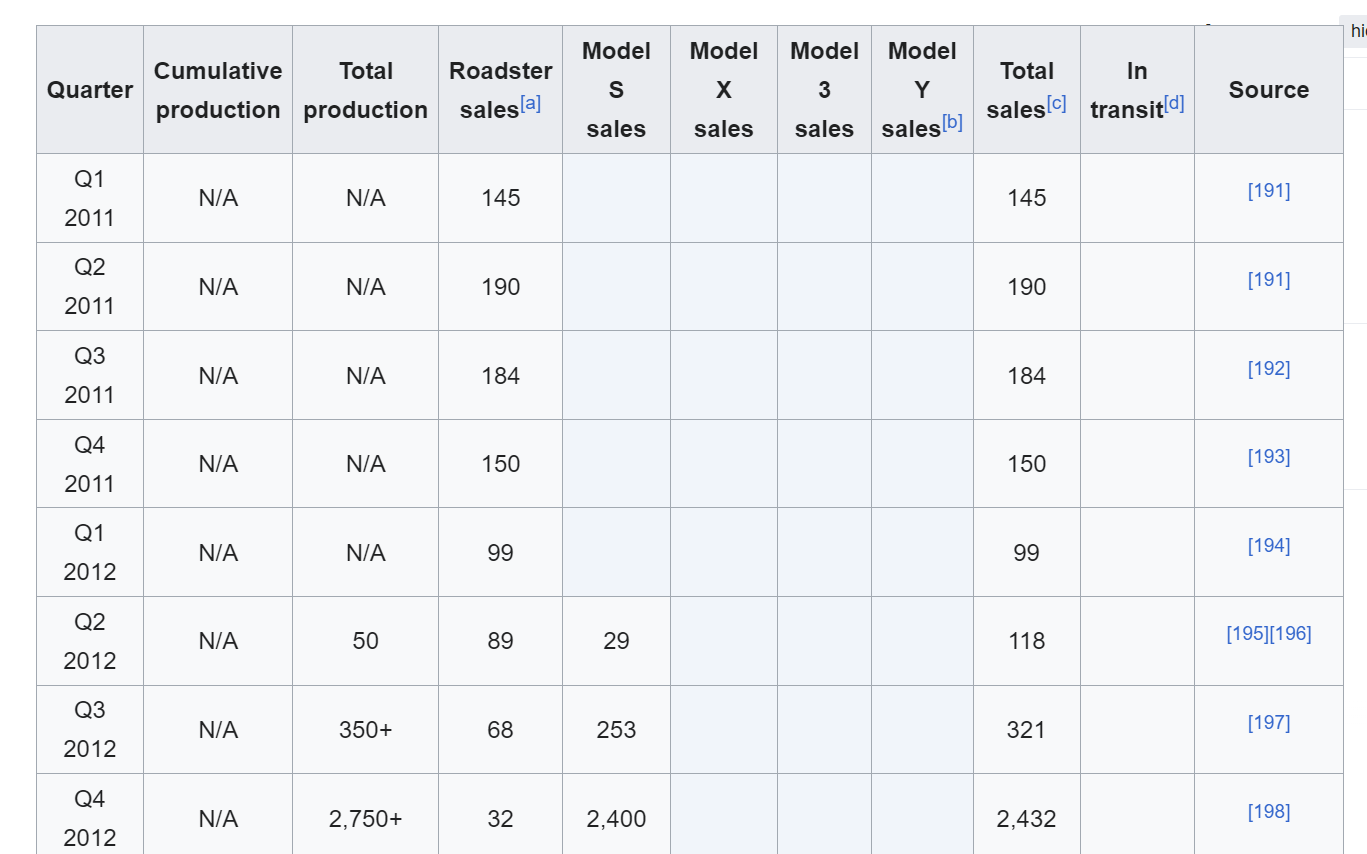

可以如何做到？

預計會遇到的困難點
1. [ ] 怎麼取得正確的 table
2. [ ] 怎麼處理表頭欄位名稱錯誤
3. [ ] 怎麼處理 空值 和 N/A
4. [ ] 怎麼處理 2,750+, ~13,450 等數字
5. [ ] 怎麼處理 數字對錯欄位的問題

延伸
1. [ ] 可以做什麼資料分析

以下是基於這個對話整理出來
https://chatgpt.com/share/685faf83-ebcc-800f-9daf-3b07a8f7a94a

詢問 ChatGPT 可以如何執行：

> 我想要用 Python 的 request 以及 beautifulsoup 套件來取得這頁 Wikipedia tesla https://en.wikipedia.org/wiki/History_of_Tesla,_Inc.#Timeline_of_production_and_sales 的銷售報告表格變成 pandas 的結構  
> 可以引導我如何完成嗎？

他會直接提供，不過我們想要引導它
補充

> 我想要一步一步來  
> 首先，下載 html 儲存成為 local 的一份，後面不需要每次都下載

In [31]:
## 安裝環境

!pip install requests beautifulsoup4 pandas


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [32]:
# 下載 HTML

import requests

url = "https://en.wikipedia.org/wiki/History_of_Tesla,_Inc."
response = requests.get(url)

# 檢查是否成功下載
if response.status_code == 200:
    with open("tesla_history.html", "w", encoding="utf-8") as f:
        f.write(response.text)
    print("✅ HTML 已成功儲存為 tesla_history.html")
else:
    print(f"❌ 無法下載頁面，狀態碼：{response.status_code}")

✅ HTML 已成功儲存為 tesla_history.html


詢問下一步

得知，要先找到是那個 table

In [33]:
from bs4 import BeautifulSoup

# 1. 讀取本地 HTML 檔案
with open("tesla_history.html", "r", encoding="utf-8") as f:
    html = f.read()

# 2. 用 BeautifulSoup 解析 HTML
soup = BeautifulSoup(html, 'html.parser')

# 3. 找出所有 class 為 wikitable 的表格
tables = soup.find_all("table", class_="wikitable")

# 4. 列出每個表格的 caption 或前幾行文字，幫助你辨認哪一個是我們要的
for i, table in enumerate(tables):
    caption = table.find("caption")
    print(f"\n🔍 表格 {i}:")
    if caption:
        print("📌 Caption:", caption.get_text(strip=True))
    else:
        print("📌 沒有 caption，前幾行內容：")
        print(table.get_text(strip=True)[:100])  # 印出前 100 字做為參考


🔍 表格 0:
📌 沒有 caption，前幾行內容：
DateAnnouncedCompanyBusinessValue (USD)ReferencesMay 8, 2015YesRiviera Tool LLCStamping die systems 

🔍 表格 1:
📌 沒有 caption，前幾行內容：
QuarterCumulativeproductionTotalproductionRoadstersales[a]Model SsalesModel XsalesModel 3salesModel 


請他用 css selector 的語法

In [34]:
from bs4 import BeautifulSoup

# 1. 讀取本地 HTML 檔案
with open("tesla_history.html", "r", encoding="utf-8") as f:
    html = f.read()

# 2. 解析 HTML
soup = BeautifulSoup(html, "html.parser")

# 3. 用 CSS selector 找出所有 .wikitable
tables = soup.select("table.wikitable")

# 4. 印出所有表格的 caption（如果有的話），方便辨認
for i, table in enumerate(tables):
    caption = table.select_one("caption")
    print(f"\n🔍 表格 {i}:")
    if caption:
        print("📌 Caption:", caption.get_text(strip=True))
    else:
        print("📌 沒有 caption，前幾行內容：")
        print(table.get_text(strip=True)[:100])



🔍 表格 0:
📌 沒有 caption，前幾行內容：
DateAnnouncedCompanyBusinessValue (USD)ReferencesMay 8, 2015YesRiviera Tool LLCStamping die systems 

🔍 表格 1:
📌 沒有 caption，前幾行內容：
QuarterCumulativeproductionTotalproductionRoadstersales[a]Model SsalesModel XsalesModel 3salesModel 


> 表格 1 是我要的，但文字都黏在了一起，可以如何把每個標題用一行一行呈現

In [35]:
# 假設你已經有 soup 和 tables

target_table = tables[1]  # 表格 1

rows = target_table.select("tr")

for i, row in enumerate(rows):
    cells = row.find_all(["th", "td"])
    cell_texts = [cell.get_text(strip=True) for cell in cells]
    print(f"🔹 第 {i} 列:", cell_texts)


🔹 第 0 列: ['Quarter', 'Cumulativeproduction', 'Totalproduction', 'Roadstersales[a]', 'Model Ssales', 'Model Xsales', 'Model 3sales', 'Model Ysales[b]', 'Totalsales[c]', 'In transit[d]', 'Source']
🔹 第 1 列: ['Q1 2011', 'N/A', 'N/A', '145', '', '', '', '', '145', '', '[191]']
🔹 第 2 列: ['Q2 2011', 'N/A', 'N/A', '190', '', '', '', '', '190', '', '[191]']
🔹 第 3 列: ['Q3 2011', 'N/A', 'N/A', '184', '', '', '', '', '184', '', '[192]']
🔹 第 4 列: ['Q4 2011', 'N/A', 'N/A', '150', '', '', '', '', '150', '', '[193]']
🔹 第 5 列: ['Q1 2012', 'N/A', 'N/A', '99', '', '', '', '', '99', '', '[194]']
🔹 第 6 列: ['Q2 2012', 'N/A', '50', '89', '29', '', '', '', '118', '', '[195][196]']
🔹 第 7 列: ['Q3 2012', 'N/A', '350+', '68', '253', '', '', '', '321', '', '[197]']
🔹 第 8 列: ['Q4 2012', 'N/A', '2,750+', '32', '2,400', '', '', '', '2,432', '', '[198]']
🔹 第 9 列: ['Q1 2013', 'N/A', '5,000+', '', '4,900', '', '', '', '4,900', '', '[199]']
🔹 第 10 列: ['Q2 2013', 'N/A', 'N/A', '', '5,150', '', '', '', '5,150', '', '[200]'

> 第 0 列看起來是標題  
🔹 第 0 列: ['Quarter', 'Cumulativeproduction', 'Totalproduction', 'Roadstersales[a]', 'Model Ssales', 'Model Xsales', 'Model 3sales', 'Model Ysales[b]', 'Totalsales[c]', 'In transit[d]', 'Source']  
但他有這種 [a] 類似 reference 的內容，可以如何拿掉？  
我想要先清理好標題的部分  

In [36]:
import re

# 抓出表格第0列（標題列）
header_row = rows[0]
header_cells = header_row.find_all(["th", "td"])

# 移除類似 [a]、[1] 的引用註記
def clean_text(text):
    return re.sub(r"\[\w+\]", "", text).strip()

# 清理後的欄位名稱
column_names = [clean_text(cell.get_text(strip=True)) for cell in header_cells]
print("🧼 清理後的欄位名稱：")
print(column_names)

🧼 清理後的欄位名稱：
['Quarter', 'Cumulativeproduction', 'Totalproduction', 'Roadstersales', 'Model Ssales', 'Model Xsales', 'Model 3sales', 'Model Ysales', 'Totalsales', 'In transit', 'Source']


> 我想要先學習不用 pandas 的方式  
目前看起來結果正確  
['Quarter', 'Cumulativeproduction', 'Totalproduction', 'Roadstersales', 'Model Ssales', 'Model Xsales', 'Model 3sales', 'Model Ysales', 'Totalsales', 'In transit', 'Source']  
有了表頭，我想要接下來處理一列一列的內容  
讓後幫我放到 dataframe 裡面

In [37]:
import re
from bs4 import BeautifulSoup
import pandas as pd

# 清理文字的函式：去掉註解 [a], [1] 等
def clean_text(text):
    return re.sub(r"\[\w+\]", "", text).strip()

# 讀取 HTML 並建立 BeautifulSoup 物件
with open("tesla_history.html", "r", encoding="utf-8") as f:
    soup = BeautifulSoup(f.read(), "html.parser")

# 找到表格
tables = soup.select("table.wikitable")
target_table = tables[1]

# 抓出所有列
rows = target_table.select("tr")

# Step 1: 抽出欄位名稱（第 0 列）
header_cells = rows[0].find_all(["th", "td"])
column_names = [clean_text(cell.get_text(strip=True)) for cell in header_cells]

# Step 2: 抽出每一列資料
data = []

for row in rows[1:]:  # 從第 1 列開始（跳過 header）
    cells = row.find_all(["th", "td"])
    if len(cells) == 0:
        continue  # 忽略空白列
    row_data = [clean_text(cell.get_text(strip=True)) for cell in cells]
    
    # 如果列數與欄位數不一致，可以跳過或補齊（視情況而定）
    if len(row_data) != len(column_names):
        print(f"⚠️ 欄位數不符：{row_data}")
        continue
    data.append(row_data)

# Step 3: 放入 DataFrame
df = pd.DataFrame(data, columns=column_names)

# 顯示前幾筆
print(df.head())


⚠️ 欄位數不符：['Q1 2019', '632,952', '77,100', '', '12,100', '50,900', '', '63,000', '10,600', '']
⚠️ 欄位數不符：['Q2 2019', '720,000', '87,048', '', '17,650', '77,550', '', '95,200', '7,400', '']
⚠️ 欄位數不符：['Q3 2019', '816,155', '96,155', '', '17,483', '79,703', '', '97,186', '', '']
⚠️ 欄位數不符：['Q4 2019', '921,046', '104,891', '', '19,475', '92,620', '', '112,095', '', '']
⚠️ 欄位數不符：['Q1 2020', '1,023,718', '102,672', '', '12,230', '76,266', '88,496', '', '']
⚠️ 欄位數不符：['Q2 2020', '1,105,990', '82,272', '', '10,614', '80,277', '90,891', '', '']
⚠️ 欄位數不符：['Q3 2020', '1,251,026', '145,036', '', '15,275', '124,318', '139,593', '', '']
⚠️ 欄位數不符：['Q4 2020', '1,430,783', '179,757', '', '18,966', '161,701', '180,667', '', '']
⚠️ 欄位數不符：['Q1 2021', '1,611,121', '180,338', '', '2,030', '182,847', '184,877', '', '']
⚠️ 欄位數不符：['Q2 2021', '1,817,542', '206,421', '', '1,895', '199,409', '201,304', '', '']
⚠️ 欄位數不符：['Q3 2021', '2,055,365', '237,823', '', '9,289', '232,102', '241,391', '', '']
⚠️ 欄位數不符：['Q4 2021',

>  我嘗試執行 出現  
⚠️ 欄位數不符：['Q1 2019', '632,952', '77,100', '', '12,100', '50,900', '', '63,000', '10,600', '']  
請問原因是什麼？ 

In [38]:
import re
from bs4 import BeautifulSoup
import pandas as pd

# ---------- 函式定義 ----------

# 清理文字，移除 [a]、[1] 這種註解
def clean_text(text):
    return re.sub(r"\[\w+\]", "", text).strip()

# ---------- HTML 載入與解析 ----------

# 從本地 html 讀取
with open("tesla_history.html", "r", encoding="utf-8") as f:
    soup = BeautifulSoup(f.read(), "html.parser")

# 選出所有 class 為 wikitable 的表格
tables = soup.select("table.wikitable")

# 假設表格 1 是目標表格
target_table = tables[1]

# 所有列
rows = target_table.select("tr")

# ---------- 解析表頭 ----------
header_cells = rows[0].find_all(["th", "td"])
column_names = [clean_text(cell.get_text(strip=True)) for cell in header_cells]
print("🧼 表頭：", column_names)

# ---------- 解析資料列 ----------
data = []

for row in rows[1:]:
    cells = row.find_all(["th", "td"])
    if len(cells) == 0:
        continue  # 空列略過

    row_data = [clean_text(cell.get_text(strip=True)) for cell in cells]

    # 補齊欄位不足的列
    if len(row_data) != len(column_names):
        print(f"⚠️ 欄位數不符，補齊中：{row_data}")
        row_data += [''] * (len(column_names) - len(row_data))

    data.append(row_data)

# ---------- 轉成 DataFrame ----------
df = pd.DataFrame(data, columns=column_names)

# ---------- 顯示結果 ----------
print("\n✅ 頭幾筆資料：")
print(df.head())


🧼 表頭： ['Quarter', 'Cumulativeproduction', 'Totalproduction', 'Roadstersales', 'Model Ssales', 'Model Xsales', 'Model 3sales', 'Model Ysales', 'Totalsales', 'In transit', 'Source']
⚠️ 欄位數不符，補齊中：['Q1 2019', '632,952', '77,100', '', '12,100', '50,900', '', '63,000', '10,600', '']
⚠️ 欄位數不符，補齊中：['Q2 2019', '720,000', '87,048', '', '17,650', '77,550', '', '95,200', '7,400', '']
⚠️ 欄位數不符，補齊中：['Q3 2019', '816,155', '96,155', '', '17,483', '79,703', '', '97,186', '', '']
⚠️ 欄位數不符，補齊中：['Q4 2019', '921,046', '104,891', '', '19,475', '92,620', '', '112,095', '', '']
⚠️ 欄位數不符，補齊中：['Q1 2020', '1,023,718', '102,672', '', '12,230', '76,266', '88,496', '', '']
⚠️ 欄位數不符，補齊中：['Q2 2020', '1,105,990', '82,272', '', '10,614', '80,277', '90,891', '', '']
⚠️ 欄位數不符，補齊中：['Q3 2020', '1,251,026', '145,036', '', '15,275', '124,318', '139,593', '', '']
⚠️ 欄位數不符，補齊中：['Q4 2020', '1,430,783', '179,757', '', '18,966', '161,701', '180,667', '', '']
⚠️ 欄位數不符，補齊中：['Q1 2021', '1,611,121', '180,338', '', '2,030', '182,847',

> 為什麼 dfhead 是這個樣子？

`1                                               190      `

In [39]:
print("欄位數：", len(column_names))
for i, row in enumerate(data[:5]):
    print(f"第 {i} 列欄位數：", len(row), "→", row)

欄位數： 11
第 0 列欄位數： 11 → ['Q1 2011', 'N/A', 'N/A', '145', '', '', '', '', '145', '', '']
第 1 列欄位數： 11 → ['Q2 2011', 'N/A', 'N/A', '190', '', '', '', '', '190', '', '']
第 2 列欄位數： 11 → ['Q3 2011', 'N/A', 'N/A', '184', '', '', '', '', '184', '', '']
第 3 列欄位數： 11 → ['Q4 2011', 'N/A', 'N/A', '150', '', '', '', '', '150', '', '']
第 4 列欄位數： 11 → ['Q1 2012', 'N/A', 'N/A', '99', '', '', '', '', '99', '', '']


In [40]:
print("欄位名稱：", column_names)
print("欄位數量：", len(column_names))


欄位名稱： ['Quarter', 'Cumulativeproduction', 'Totalproduction', 'Roadstersales', 'Model Ssales', 'Model Xsales', 'Model 3sales', 'Model Ysales', 'Totalsales', 'In transit', 'Source']
欄位數量： 11


In [41]:
print(df.head())


   Quarter Cumulativeproduction Totalproduction Roadstersales Model Ssales  \
0  Q1 2011                  N/A             N/A           145                
1  Q2 2011                  N/A             N/A           190                
2  Q3 2011                  N/A             N/A           184                
3  Q4 2011                  N/A             N/A           150                
4  Q1 2012                  N/A             N/A            99                

  Model Xsales Model 3sales Model Ysales Totalsales In transit Source  
0                                               145                    
1                                               190                    
2                                               184                    
3                                               150                    
4                                                99                    


用 Data Wrangle 發現資料有問題
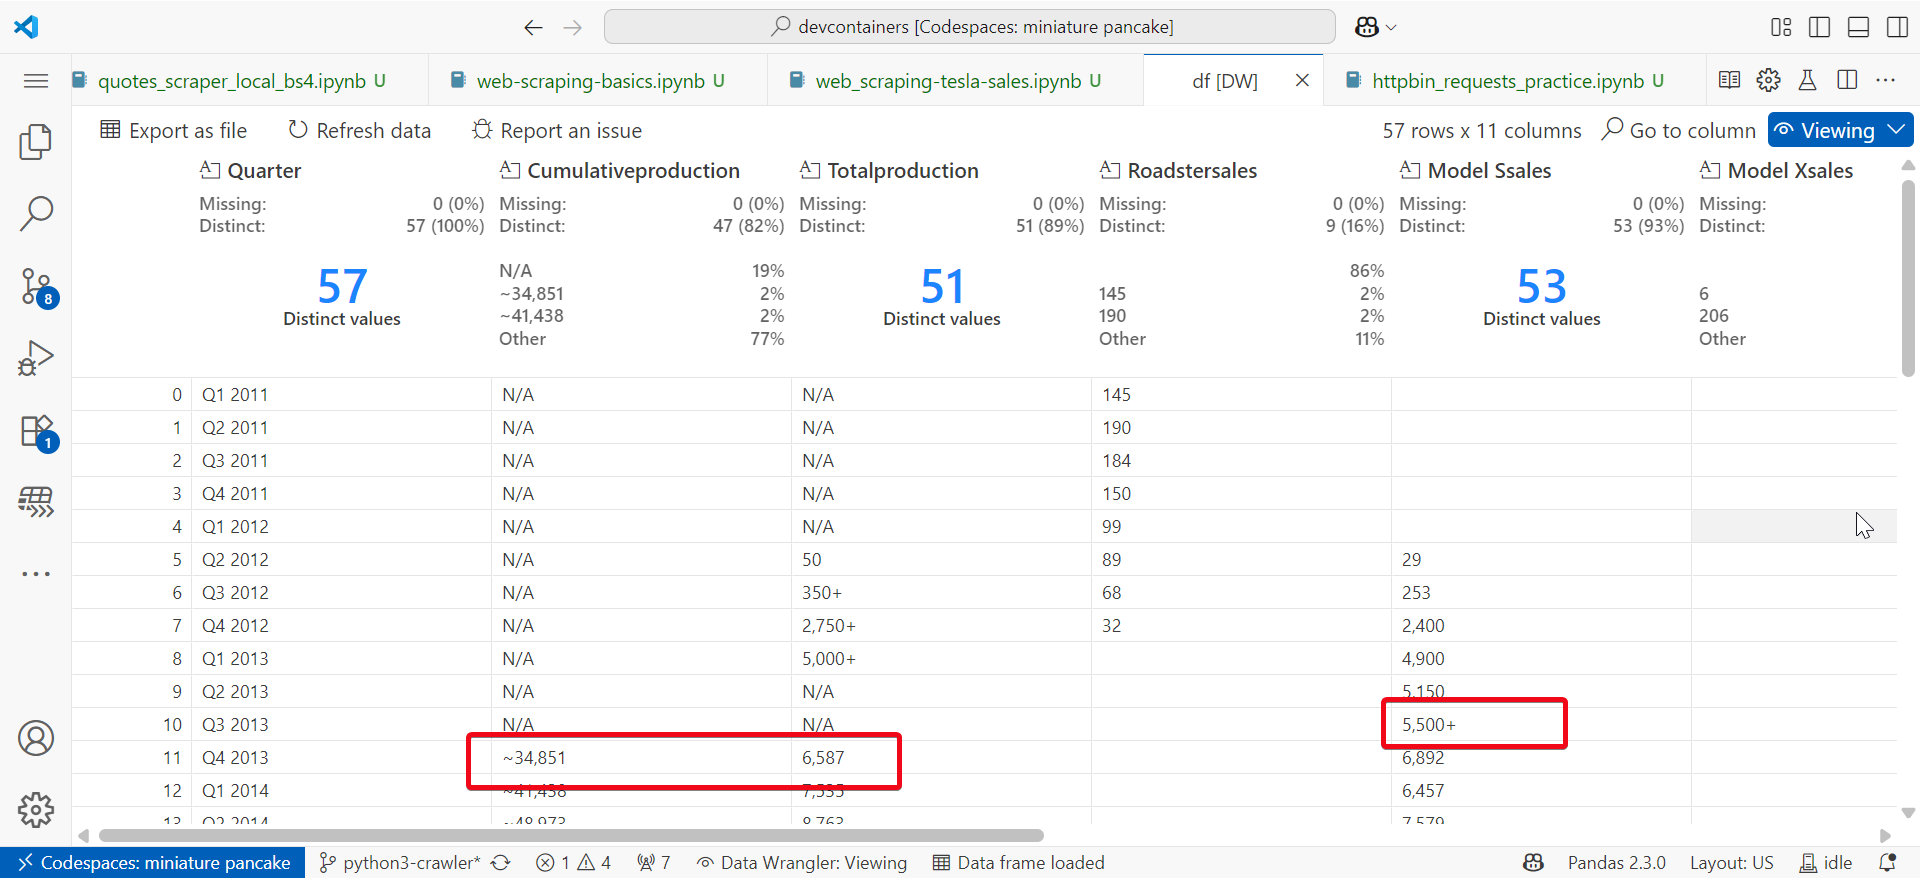

```
我看到數字欄位有些是

~13,450
25,708
N/A
5,500+

可以幫我把這些都正確轉換嗎？

如果是 N/A 或者 空 就是 0
如果有 , 或者 ~ + 就直接忽略
```

In [42]:
import re
from bs4 import BeautifulSoup
import pandas as pd

def clean_text(text):
    return re.sub(r"\[\w+\]", "", text).strip()

def split_camel_case(s):
    return re.sub(r'([a-z])([A-Z])', r'\1 \2', s)

def parse_number(s):
    if not s or s.strip() in ['N/A', '-']:
        return 0
    s = s.replace('~', '').replace('+', '').replace(',', '').strip()
    if s == '':
        return 0
    try:
        return int(s)
    except ValueError:
        return 0

# 載入 HTML
with open("tesla_history.html", "r", encoding="utf-8") as f:
    soup = BeautifulSoup(f.read(), "html.parser")

tables = soup.select("table.wikitable")
target_table = tables[1]
rows = target_table.select("tr")

# 取得欄位名稱並清理
header_cells = rows[0].find_all(["th", "td"])
column_names = [split_camel_case(clean_text(cell.get_text(strip=True))) for cell in header_cells]

# 定義哪些欄位是數字欄位（依你需要調整）
num_cols = [
    'Cumulative production',
    'Total production',
    'Roadster sales',
    'Model S sales',
    'Model X sales',
    'Model 3 sales',
    'Model Y sales',
    'Total sales',
    'In transit',
]

data = []
for row in rows[1:]:
    cells = row.find_all(["th", "td"])
    if len(cells) == 0:
        continue
    row_data_raw = [clean_text(cell.get_text(strip=True)) for cell in cells]

    # 補齊欄位
    if len(row_data_raw) != len(column_names):
        row_data_raw += [''] * (len(column_names) - len(row_data_raw))

    # 轉換數字欄位
    row_data = []
    for col_name, cell_text in zip(column_names, row_data_raw):
        if col_name in num_cols:
            row_data.append(parse_number(cell_text))
        else:
            row_data.append(cell_text)
    data.append(row_data)

df = pd.DataFrame(data, columns=column_names)

print(df.head())


   Quarter Cumulativeproduction Totalproduction Roadstersales Model Ssales  \
0  Q1 2011                  N/A             N/A           145                
1  Q2 2011                  N/A             N/A           190                
2  Q3 2011                  N/A             N/A           184                
3  Q4 2011                  N/A             N/A           150                
4  Q1 2012                  N/A             N/A            99                

  Model Xsales Model 3sales Model Ysales Totalsales  In transit Source  
0                                               145           0         
1                                               190           0         
2                                               184           0         
3                                               150           0         
4                                                99           0         


```
我發現 column header 名稱不太對

   Quarter Cumulativeproduction Totalproduction Roadstersales Model Ssales    Model Xsales Model 3sales Model Ysales Totalsales  In transit Source  


應該是
 Quarter 
Cumulative production 
Total production 
Roadster sales 
Model S sales
以此類推

請問如何修復這個
```

In [43]:
import re
from bs4 import BeautifulSoup
import pandas as pd

def clean_text(text):
    # 移除方括號裡的註解 [a], [1] 等
    return re.sub(r"\[\w+\]", "", text).strip()

def split_camel_case(s):
    # 在小寫字母後接大寫字母處加空格
    return re.sub(r'([a-z])([A-Z])', r'\1 \2', s)

def clean_and_split_header(text):
    text = clean_text(text)
    text = split_camel_case(text)
    return text

def parse_number(s):
    if not s or s.strip() in ['N/A', '-']:
        return 0
    s = s.replace('~', '').replace('+', '').replace(',', '').strip()
    if s == '':
        return 0
    try:
        return int(s)
    except ValueError:
        return 0

# 讀取本地 HTML 檔案
with open("tesla_history.html", "r", encoding="utf-8") as f:
    soup = BeautifulSoup(f.read(), "html.parser")

# 選取所有 class 為 wikitable 的表格
tables = soup.select("table.wikitable")
target_table = tables[1]  # 目標表格是第 2 個（index=1）

rows = target_table.select("tr")

# 解析欄位名稱並清理
header_cells = rows[0].find_all(["th", "td"])
column_names = [clean_and_split_header(cell.get_text(strip=True)) for cell in header_cells]

print("🧼 清理後的欄位名稱：")
print(column_names)

# 定義要轉成數字的欄位名稱（注意跟清理後的欄位名稱對齊）
num_cols = [
    'Cumulative production',
    'Total production',
    'Roadster sales',
    'Model S sales',
    'Model X sales',
    'Model 3 sales',
    'Model Y sales',
    'Total sales',
    'In transit',
]

data = []
for row in rows[1:]:
    cells = row.find_all(["th", "td"])
    if len(cells) == 0:
        continue

    row_data_raw = [clean_text(cell.get_text(strip=True)) for cell in cells]

    # 補齊欄位數不足的列
    if len(row_data_raw) != len(column_names):
        row_data_raw += [''] * (len(column_names) - len(row_data_raw))

    # 數字欄位轉換
    row_data = []
    for col_name, cell_text in zip(column_names, row_data_raw):
        if col_name in num_cols:
            row_data.append(parse_number(cell_text))
        else:
            row_data.append(cell_text)
    data.append(row_data)

df = pd.DataFrame(data, columns=column_names)

print("\n✅ DataFrame 前五筆資料：")
print(df.head())


🧼 清理後的欄位名稱：
['Quarter', 'Cumulativeproduction', 'Totalproduction', 'Roadstersales', 'Model Ssales', 'Model Xsales', 'Model 3sales', 'Model Ysales', 'Totalsales', 'In transit', 'Source']

✅ DataFrame 前五筆資料：
   Quarter Cumulativeproduction Totalproduction Roadstersales Model Ssales  \
0  Q1 2011                  N/A             N/A           145                
1  Q2 2011                  N/A             N/A           190                
2  Q3 2011                  N/A             N/A           184                
3  Q4 2011                  N/A             N/A           150                
4  Q1 2012                  N/A             N/A            99                

  Model Xsales Model 3sales Model Ysales Totalsales  In transit Source  
0                                               145           0         
1                                               190           0         
2                                               184           0         
3                                

```
還是錯的
🧼 清理後的欄位名稱：

['Quarter', 'Cumulativeproduction', 'Totalproduction', 'Roadstersales', 'Model Ssales', 'Model Xsales', 'Model 3sales', 'Model Ysales', 'Totalsales', 'In transit', 'Source']
```

In [44]:
import re
from bs4 import BeautifulSoup
import pandas as pd

# 欄位名稱字串對照表
COLUMN_NAME_MAPPING = {
    'Cumulativeproduction': 'Cumulative production',
    'Totalproduction': 'Total production',
    'Roadstersales': 'Roadster sales',
    'Model Ssales': 'Model S sales',
    'Model Xsales': 'Model X sales',
    'Model 3sales': 'Model 3 sales',
    'Model Ysales': 'Model Y sales',
    'Totalsales': 'Total sales',
}

def clean_text(text):
    # 移除 [a]、[1] 等註解標記
    return re.sub(r"\[\w+\]", "", text).strip()

def split_camel_case(s):
    # 在小寫字母後接大寫字母處加空格
    return re.sub(r'([a-z])([A-Z])', r'\1 \2', s)

def clean_and_map_header(text):
    text = clean_text(text)
    text = COLUMN_NAME_MAPPING.get(text, text)
    text = split_camel_case(text)
    return text

def parse_number(s):
    if not s or s.strip() in ['N/A', '-']:
        return 0
    s = s.replace('~', '').replace('+', '').replace(',', '').strip()
    if s == '':
        return 0
    try:
        return int(s)
    except ValueError:
        return 0

# 讀取本地 HTML 檔案
with open("tesla_history.html", "r", encoding="utf-8") as f:
    soup = BeautifulSoup(f.read(), "html.parser")

# 找到所有 wiki table，選第二個表格（index=1）
tables = soup.select("table.wikitable")
target_table = tables[1]

rows = target_table.select("tr")

# 解析欄位名稱
header_cells = rows[0].find_all(["th", "td"])
column_names = [clean_and_map_header(cell.get_text(strip=True)) for cell in header_cells]

print("🧼 清理並修正後欄位名稱：")
print(column_names)

# 指定數字欄位名稱（要與清理後名稱一致）
num_cols = [
    'Cumulative production',
    'Total production',
    'Roadster sales',
    'Model S sales',
    'Model X sales',
    'Model 3 sales',
    'Model Y sales',
    'Total sales',
    'In transit',
]

data = []
for row in rows[1:]:
    cells = row.find_all(["th", "td"])
    if len(cells) == 0:
        continue

    row_data_raw = [clean_text(cell.get_text(strip=True)) for cell in cells]

    # 補齊欄位數不足
    if len(row_data_raw) != len(column_names):
        row_data_raw += [''] * (len(column_names) - len(row_data_raw))

    # 針對數字欄位做轉換
    row_data = []
    for col_name, cell_text in zip(column_names, row_data_raw):
        if col_name in num_cols:
            row_data.append(parse_number(cell_text))
        else:
            row_data.append(cell_text)
    data.append(row_data)

df = pd.DataFrame(data, columns=column_names)

print("\n✅ DataFrame 頭五筆：")
print(df.head())


🧼 清理並修正後欄位名稱：
['Quarter', 'Cumulative production', 'Total production', 'Roadster sales', 'Model S sales', 'Model X sales', 'Model 3 sales', 'Model Y sales', 'Total sales', 'In transit', 'Source']

✅ DataFrame 頭五筆：
   Quarter  Cumulative production  Total production  Roadster sales  \
0  Q1 2011                      0                 0             145   
1  Q2 2011                      0                 0             190   
2  Q3 2011                      0                 0             184   
3  Q4 2011                      0                 0             150   
4  Q1 2012                      0                 0              99   

   Model S sales  Model X sales  Model 3 sales  Model Y sales  Total sales  \
0              0              0              0              0          145   
1              0              0              0              0          190   
2              0              0              0              0          184   
3              0              0              0 

```
現在 DataFrame 看起來正常了

如果我要分析這個 Data Frame 有什麼建議嗎？
```

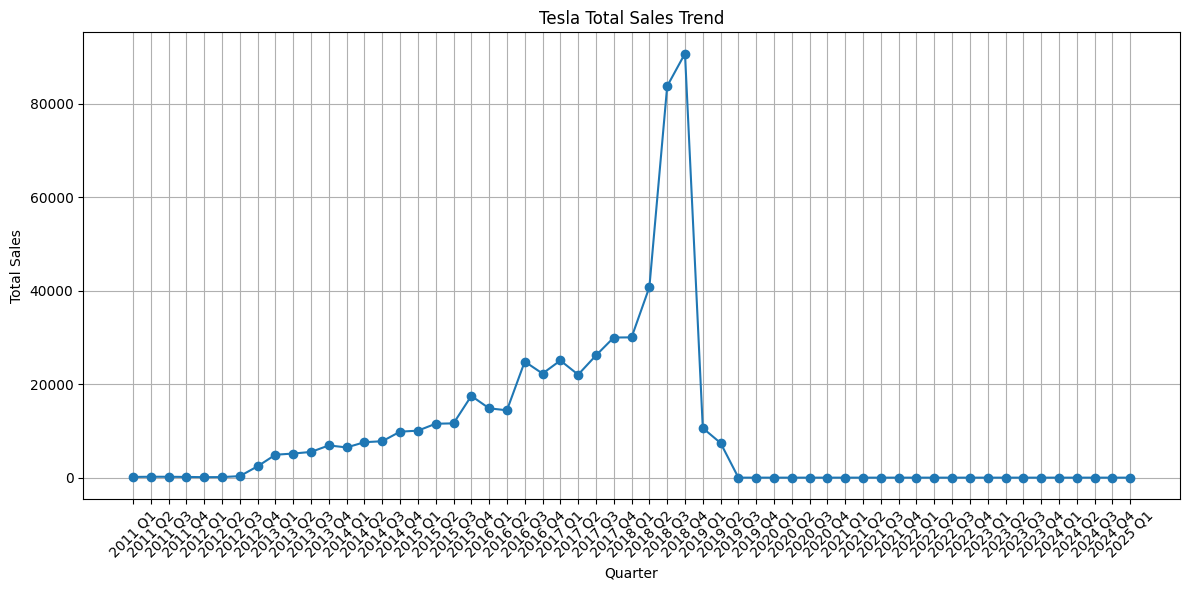

In [45]:
import re
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt

# --- 前面爬取並清理的程式碼（假設已完成） ---
# 為了完整起見，示範直接從前面整理好的 df 開始

# 假設 df 是你已經有的 DataFrame，欄位有 'Quarter' 和 'Total sales'
# 先示範從原始 df 進行後續分析

# 1. 拆分 Quarter 欄位成 Year 與 Quarter_num
df[['Quarter_num', 'Year']] = df['Quarter'].str.split(' ', expand=True)
df['Year'] = df['Year'].astype(int)
df['Quarter_num'] = df['Quarter_num'].str.replace('Q', '').astype(int)

# 2. 排序
df_sorted = df.sort_values(['Year', 'Quarter_num'])

# 3. 畫折線圖
plt.figure(figsize=(12, 6))
x_labels = df_sorted['Year'].astype(str) + ' Q' + df_sorted['Quarter_num'].astype(str)
plt.plot(x_labels, df_sorted['Total sales'], marker='o', linestyle='-')

plt.xticks(rotation=45)
plt.title('Tesla Total Sales Trend')
plt.xlabel('Quarter')
plt.ylabel('Total Sales')
plt.grid(True)
plt.tight_layout()
plt.show()


```
執行出錯

ModuleNotFoundError: No module named 'matplotlib'
```

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


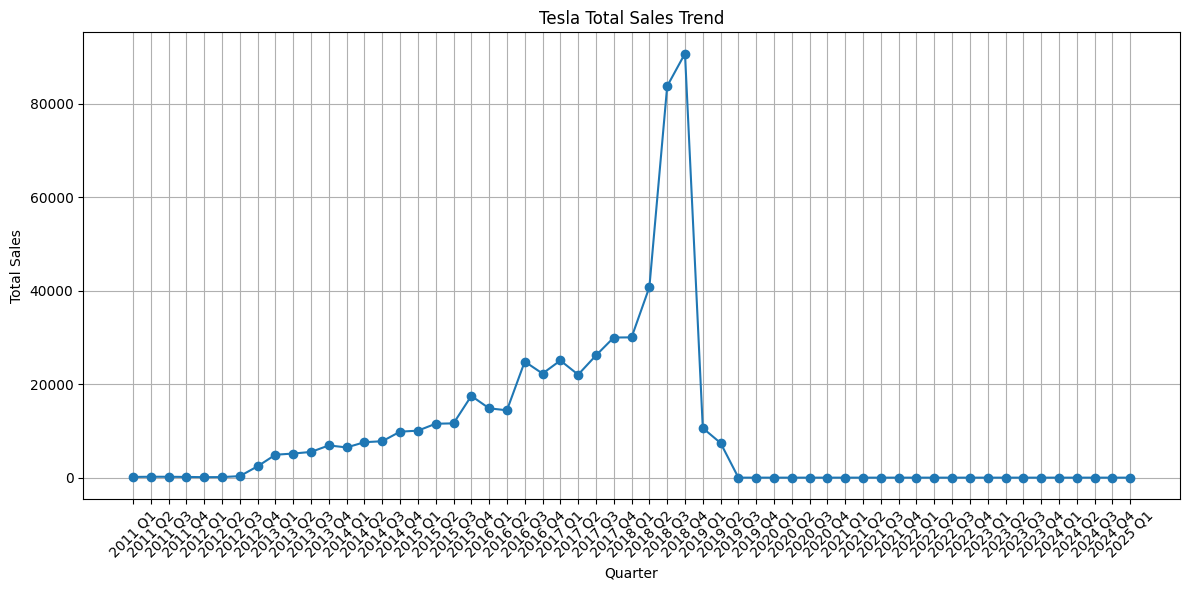

In [46]:
!pip install matplotlib

import re
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt

# --- 前面爬取並清理的程式碼（假設已完成） ---
# 為了完整起見，示範直接從前面整理好的 df 開始

# 假設 df 是你已經有的 DataFrame，欄位有 'Quarter' 和 'Total sales'
# 先示範從原始 df 進行後續分析

# 1. 拆分 Quarter 欄位成 Year 與 Quarter_num
df[['Quarter_num', 'Year']] = df['Quarter'].str.split(' ', expand=True)
df['Year'] = df['Year'].astype(int)
df['Quarter_num'] = df['Quarter_num'].str.replace('Q', '').astype(int)

# 2. 排序
df_sorted = df.sort_values(['Year', 'Quarter_num'])

# 3. 畫折線圖
plt.figure(figsize=(12, 6))
x_labels = df_sorted['Year'].astype(str) + ' Q' + df_sorted['Quarter_num'].astype(str)
plt.plot(x_labels, df_sorted['Total sales'], marker='o', linestyle='-')

plt.xticks(rotation=45)
plt.title('Tesla Total Sales Trend')
plt.xlabel('Quarter')
plt.ylabel('Total Sales')
plt.grid(True)
plt.tight_layout()
plt.show()


```
我發現從 Q3 2019 之後的 total sales 資料都不對

您可以幫我在看看這個 table 是不是 parsing 那邊沒處理好？
```

再來提供範例

```
我給您幾個片段
<tr style="text-align:center;">
<td>Q3 2019</td>
<td>816,155</td>
<td>96,155
</td>
<td></td>
<td colspan="2">17,483</td>
<td>79,703</td>
<td style="background:#f1f5fa;"></td>
<td>97,186</td>
<td></td>
<td><sup class="reference" id="cite_ref-Tesla3Q2019_238-0"><a href="#cite_note-Tesla3Q2019-238"><span class="cite-bracket">[</span>233<span class="cite-bracket">]</span></a></sup>
</td></tr>
```

注意到 colspan

In [47]:
import re
from bs4 import BeautifulSoup
import pandas as pd

# 欄位名稱字串對照表
COLUMN_NAME_MAPPING = {
    'Cumulativeproduction': 'Cumulative production',
    'Totalproduction': 'Total production',
    'Roadstersales': 'Roadster sales',
    'Model Ssales': 'Model S sales',
    'Model Xsales': 'Model X sales',
    'Model 3sales': 'Model 3 sales',
    'Model Ysales': 'Model Y sales',
    'Totalsales': 'Total sales',
}

def clean_text(text):
    # 移除 [a]、[1] 等註解標記
    return re.sub(r"\[\w+\]", "", text).strip()

def split_camel_case(s):
    # 在小寫字母後接大寫字母處加空格
    return re.sub(r'([a-z])([A-Z])', r'\1 \2', s)

def clean_and_map_header(text):
    text = clean_text(text)
    text = COLUMN_NAME_MAPPING.get(text, text)
    text = split_camel_case(text)
    return text

def parse_number(s):
    if not s or s.strip() in ['N/A', '-']:
        return 0
    s = s.replace('~', '').replace('+', '').replace(',', '').strip()
    if s == '':
        return 0
    try:
        return int(s)
    except ValueError:
        return 0

def get_cells_with_colspan(tr):
    cells = []
    for cell in tr.find_all(['th', 'td']):
        colspan = int(cell.get('colspan', 1))
        text = clean_text(cell.get_text(strip=True))
        for _ in range(colspan):
            cells.append(text)
    return cells

# 讀取本地 HTML 檔案
with open("tesla_history.html", "r", encoding="utf-8") as f:
    soup = BeautifulSoup(f.read(), "html.parser")

# 找到所有 wiki table，選第二個表格（index=1）
tables = soup.select("table.wikitable")
target_table = tables[1]

rows = target_table.select("tr")

# 解析欄位名稱
header_cells = get_cells_with_colspan(rows[0])
column_names = [clean_and_map_header(cell) for cell in header_cells]

print("🧼 清理並修正後欄位名稱：")
print(column_names)

# 指定數字欄位名稱（要與清理後名稱一致）
num_cols = [
    'Cumulative production',
    'Total production',
    'Roadster sales',
    'Model S sales',
    'Model X sales',
    'Model 3 sales',
    'Model Y sales',
    'Total sales',
    'In transit',
]

data = []
for row in rows[1:]:
    row_data_raw = get_cells_with_colspan(row)
    
    # 補齊欄位數不足
    if len(row_data_raw) < len(column_names):
        row_data_raw += [''] * (len(column_names) - len(row_data_raw))
    elif len(row_data_raw) > len(column_names):
        row_data_raw = row_data_raw[:len(column_names)]

    # 針對數字欄位做轉換
    row_data = []
    for col_name, cell_text in zip(column_names, row_data_raw):
        if col_name in num_cols:
            row_data.append(parse_number(cell_text))
        else:
            row_data.append(cell_text)
    data.append(row_data)

df = pd.DataFrame(data, columns=column_names)

print("\n✅ DataFrame 頭五筆：")
print(df.head())


🧼 清理並修正後欄位名稱：
['Quarter', 'Cumulative production', 'Total production', 'Roadster sales', 'Model S sales', 'Model X sales', 'Model 3 sales', 'Model Y sales', 'Total sales', 'In transit', 'Source']

✅ DataFrame 頭五筆：
   Quarter  Cumulative production  Total production  Roadster sales  \
0  Q1 2011                      0                 0             145   
1  Q2 2011                      0                 0             190   
2  Q3 2011                      0                 0             184   
3  Q4 2011                      0                 0             150   
4  Q1 2012                      0                 0              99   

   Model S sales  Model X sales  Model 3 sales  Model Y sales  Total sales  \
0              0              0              0              0          145   
1              0              0              0              0          190   
2              0              0              0              0          184   
3              0              0              0 

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


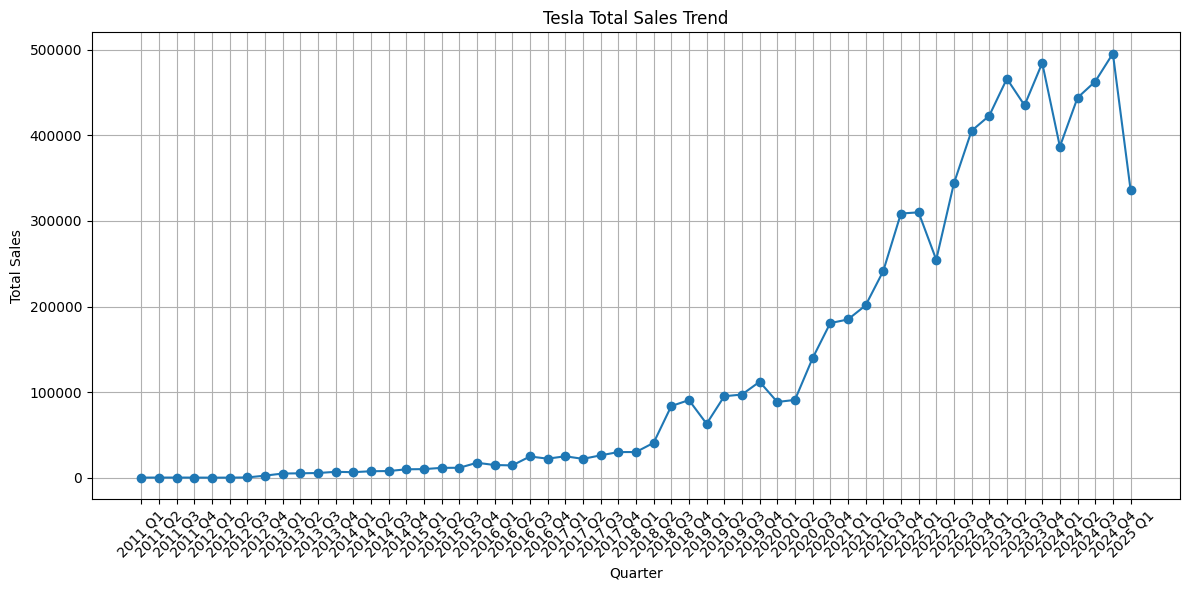

In [48]:
!pip install matplotlib

import re
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt

# --- 前面爬取並清理的程式碼（假設已完成） ---
# 為了完整起見，示範直接從前面整理好的 df 開始

# 假設 df 是你已經有的 DataFrame，欄位有 'Quarter' 和 'Total sales'
# 先示範從原始 df 進行後續分析

# 1. 拆分 Quarter 欄位成 Year 與 Quarter_num
df[['Quarter_num', 'Year']] = df['Quarter'].str.split(' ', expand=True)
df['Year'] = df['Year'].astype(int)
df['Quarter_num'] = df['Quarter_num'].str.replace('Q', '').astype(int)

# 2. 排序
df_sorted = df.sort_values(['Year', 'Quarter_num'])

# 3. 畫折線圖
plt.figure(figsize=(12, 6))
x_labels = df_sorted['Year'].astype(str) + ' Q' + df_sorted['Quarter_num'].astype(str)
plt.plot(x_labels, df_sorted['Total sales'], marker='o', linestyle='-')

plt.xticks(rotation=45)
plt.title('Tesla Total Sales Trend')
plt.xlabel('Quarter')
plt.ylabel('Total Sales')
plt.grid(True)
plt.tight_layout()
plt.show()
